In [1]:
from Maximus_optimized_non_dominated import Multi_Fair as maximus
from sklearn.model_selection import StratifiedShuffleSplit as ss
from DataPreprocessing.my_utils import get_score,get_fairness,vis
import numpy as np

In [2]:
from DataPreprocessing.load_credit import load_credit
X, y, sa_index, p_Group, x_control,F = load_credit()
protected=[F[v] for v in sa_index]
dt='Credit'

[2.659488361359545, -1.1375335092714727]
Features we will be using for classification are: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target'] 



In [3]:
sss = ss(n_splits=2,test_size=0.4) #for reporting experiments use n_splits=10
preference=[[0,0,1],[0,1,1],[1,0,0],[1,1,0],[1,0,1],[0,1,0],[1.0,0.05,0.05]]

In [4]:
X = X[:5000,:]
y = y[:5000]

In [5]:
soln_per_dir={}
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf=maximus(n_estimators=499,saIndex=sa_index,
        saValue=p_Group,
        preference=preference)
    clf.fit(X_train,y_train)
    print(clf.preference_direction_to_solution_mapping)
    # caling clf.PF will give the pareto front
    for (a,b,c) in clf.preference_direction_to_solution_mapping:
        clf.estimators_=clf.estimators_[:c]
        clf.estimator_alphas_=clf.estimator_alphas_[:c]
        pred=clf.predict(X_test)
        #print(confusion_matrix(y_test,pred))
        if str(a) in soln_per_dir:
            soln_per_dir[str(a)].append([test_index,pred])
        else:
            soln_per_dir[str(a)]=[]
            soln_per_dir[str(a)].append([test_index,pred])


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

[(array([1.  , 0.05, 0.05]), array([0.32766667, 0.12295243, 0.01357324]), 444), (array([1., 0., 1.]), array([0.28133333, 0.02358578, 0.03573902]), 328), (array([0., 0., 1.]), array([0.21866667, 0.23365035, 0.02912338]), 175), (array([0., 1., 1.]), array([0.20333333, 0.47769847, 0.03422635]), 45), (array([0., 1., 0.]), array([0.22133333, 1.        , 0.        ]), 2)]
[(array([1., 0., 1.]), array([0.277     , 0.00787568, 0.07432624]), 233), (array([0., 0., 1.]), array([0.20766667, 0.26518402, 0.02998822]), 204), (array([0., 1., 1.]), array([0.18933333, 0.56337164, 0.0465931 ]), 47), (array([0., 1., 0.]), array([0.20366667, 0.83894826, 0.02023814]), 8)]


In [6]:
len(clf.all_PF_iterations)

500

In [7]:
clf.map_cosd

[[array([0., 0., 1.]), array([0.206     , 0.33888637, 0.08296131])],
 [array([0., 1., 1.]), array([0.189     , 0.61021827, 0.0693905 ])],
 [array([1., 0., 0.]), array([0.27733333, 0.01131581, 0.03792296])],
 [array([1., 1., 0.]), array([0.22133333, 1.        , 0.        ])],
 [array([1., 0., 1.]), array([0.28866667, 0.00256334, 0.0655506 ])],
 [array([0., 1., 0.]), array([0.22133333, 1.        , 0.        ])],
 [array([1.  , 0.05, 0.05]), array([0.27733333, 0.01131581, 0.03792296])]]

In [8]:
clf.preference_direction_to_solution_mapping

[(array([1., 0., 1.]), array([0.277     , 0.00787568, 0.07432624]), 233),
 (array([0., 0., 1.]), array([0.20766667, 0.26518402, 0.02998822]), 204),
 (array([0., 1., 1.]), array([0.18933333, 0.56337164, 0.0465931 ]), 47),
 (array([0., 1., 0.]), array([0.20366667, 0.83894826, 0.02023814]), 8)]

(101, 3)


<Figure size 432x288 with 0 Axes>

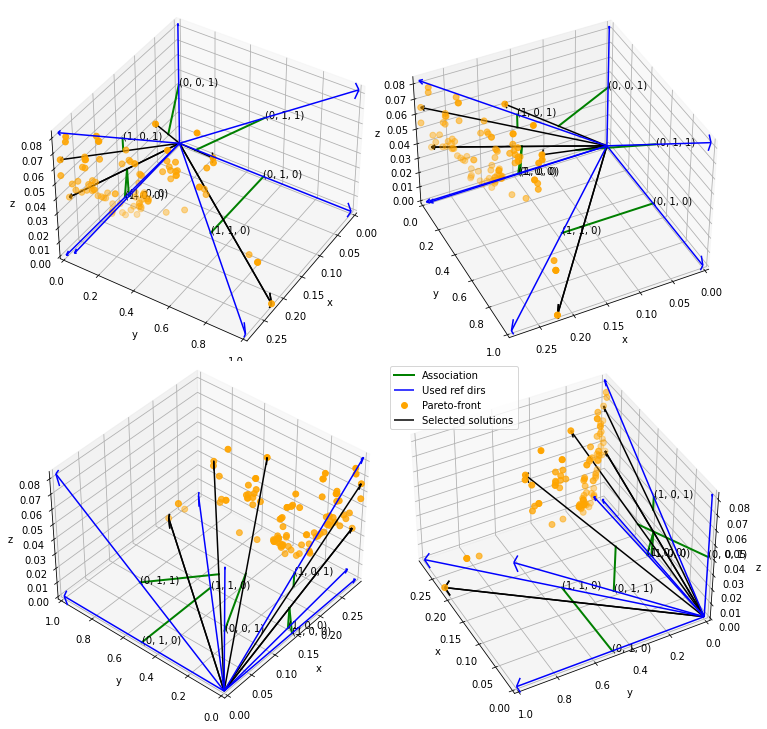

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.interpolate
from matplotlib.tri import Triangulation

def plot_pareto_front(associations, all_preference_vectors=None, full_pareto_front=None):
    plt.clf()
        
    fig = plt.figure(figsize=(10,10))
    #fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i, angle in enumerate([32, 64, 220, 152]):
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        
        # TODO maybe adjust elevation?
        ax.view_init(elev=40., azim=angle)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        
        final_selected_solutions = np.row_stack([r[1] for r in associations])

        used_ref_dirs = np.row_stack([r[0] for r in associations])
        unused_ref_dirs = []
        for row in all_preference_vectors:
            isin = False
            for used_row in used_ref_dirs:
                if np.array_equal(row, used_row):
                    isin = True
            if not isin:    
                unused_ref_dirs.append(row)
        if len(unused_ref_dirs) > 0:
            unused_ref_dirs = np.row_stack(unused_ref_dirs).T
        used_ref_dirs = used_ref_dirs.T

        # if we use final_selected_solutions for the max instead of
        # pareto_front, then we focus on the selected solutions, but
        # some of the complete pareto_front are not shown in the plot!
        # I think it makes sense this way though
        scale_factor_x = 1.0 / max(final_selected_solutions[:,0])
        scale_factor_y = 1.0 / max(final_selected_solutions[:,1])
        scale_factor_z = 1.0 / max(final_selected_solutions[:,2])

        #scale_factor_x, scale_factor_y, scale_factor_z = (1.0,1.0,1.0)

        orig_used_ref_dirs = used_ref_dirs.copy().T

        used_ref_dirs[0,:] /= scale_factor_x
        used_ref_dirs[1,:] /= scale_factor_y
        used_ref_dirs[2,:] /= scale_factor_z

        if len(unused_ref_dirs) > 0:
            unused_ref_dirs[0,:] /= scale_factor_x
            unused_ref_dirs[1,:] /= scale_factor_y
            unused_ref_dirs[2,:] /= scale_factor_z

        ax.set_xlim(0,1/scale_factor_x)
        ax.set_ylim(0,1/scale_factor_y)
        ax.set_zlim(0,1/scale_factor_z)

        ratio = 0.02

        #print(used_ref_dirs)
        #print(unused_ref_dirs)

        x, y, z = np.zeros((3,used_ref_dirs.shape[1]))
        u, v, w = used_ref_dirs
        ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                  color="blue", label="Used ref dirs", zorder=0)

        if len(unused_ref_dirs) > 0:
            x, y, z = np.zeros((3,unused_ref_dirs.shape[1]))
            u, v, w = unused_ref_dirs
            ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                      color="red", label="Unused ref dirs", zorder=0)

        for i,row in enumerate(orig_used_ref_dirs):
            x,y,z = row
            label = '(%d, %d, %d)' % (x, y, z)
            xx, yy, zz = used_ref_dirs.T[i,:] / 2
            ax.text(xx, yy, zz, label)

        ax.scatter(xs=full_pareto_front[:,0],ys=full_pareto_front[:,1],zs=full_pareto_front[:,2],label="Pareto-front",
                   color="orange", s=35, zorder=1)

        #x,y,z = full_pareto_front.T
        #triang = Triangulation(x,y)
        #ax.plot_trisurf(triang, z, color='green', shade=True, alpha=0.5)

        """
        x_grid = np.linspace(0, max(final_selected_solutions[:,0]), 1*len(x))
        y_grid = np.linspace(0, max(final_selected_solutions[:,1]), 1*len(y))
        X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')
        spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=0.1)#, episilon=5)
        Z = spline(X,Y)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                        cmap='winter', edgecolor='none')
        """
        """
        x_grid = np.linspace(0, max(final_selected_solutions[:,0]), 1*len(x))
        y_grid = np.linspace(0, max(final_selected_solutions[:,1]), 1*len(y))
        B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
        Z = np.zeros((x.size, z.size))
        spline = sp.interpolate.Rbf(x,y,z,function='thin_plate',smooth=0.1)#, episilon=5)
        Z = spline(B1,B2)
        ax.plot_wireframe(B1, B2, Z, zorder=1)
        ax.plot_surface(B1, B2, Z,alpha=0.2,zorder=1)
        """

        #print(final_selected_solutions)
        final_selected_solutions = final_selected_solutions.T
        #ax.scatter(xs=final_selected_solutions[:,0],ys=final_selected_solutions[:,1],zs=final_selected_solutions[:,2],label="Pareto-front",
        #           color="k", s=35)
        x, y, z = np.zeros((3,final_selected_solutions.shape[1]))
        u, v, w = final_selected_solutions
        ax.quiver(x,y,z,u,v,w,arrow_length_ratio=ratio,
                  color="black", label="Selected solutions", zorder=2)

        for i, row in enumerate(final_selected_solutions.T):
            associated_vector = used_ref_dirs.T[i,:]
            x,y,z = row / 2
            xx,yy,zz = associated_vector / 2
            ax.plot([x,xx],[y,yy],[z,zz],color="green",linewidth=2, label="Association" if i==0 else None, zorder=2)

        
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("pareto_front_with_ref_dirs.pdf")
    plt.show()
    
full_pareto_front = np.array(list(clf.PF.values()))
print(full_pareto_front.shape)

plot_pareto_front(clf.map_cosd, np.array(clf.preference), full_pareto_front)

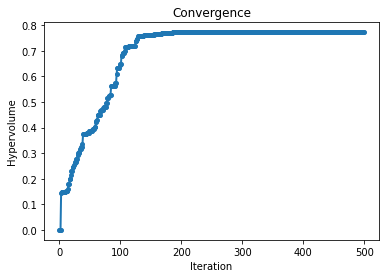

In [94]:
from pymoo.performance_indicator.hv import Hypervolume

def plot_hypervolume(pareto_fronts):
    # MODIFY - this is problem dependend
    ref_point = np.array([1.0, 1.0, 1.0])

    # create the performance indicator object with reference point
    metric = Hypervolume(ref_point=ref_point, normalize=False)

    # calculate for each generation the HV metric
    hv = [metric.calc(f) for f in pareto_fronts]
    
    n_evals = np.arange(len(hv))
    # visualze the convergence curve
    plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2)
    plt.title("Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Hypervolume")
    plt.savefig("hypervolume_convergence.pdf", dpi=300)
    plt.show()
    
plot_hypervolume(clf.all_PF_iterations)

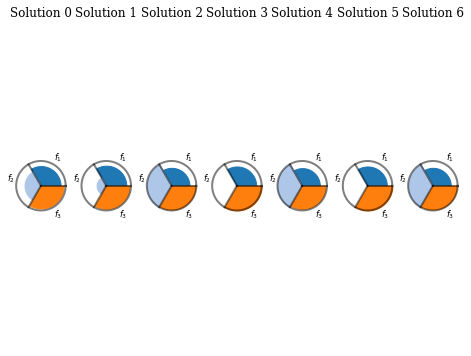

In [72]:
from pymoo.visualization.petal import Petal

F = np.array([x[1] for x in clf.map_cosd])
F = 1.0 - F # for better visualization invert the fitness
# now higher value is better
plot = Petal(bounds=[0, 1], title=["Solution %s" % t for t in range(len(F))],
             cmap="tab20",
             #labels=["profit", "cost", "sustainability"]  # TODO
            )
plot.add(F)
plot.show()

In [25]:
np.array([x[1] for x in clf.preference_direction_to_solution_mapping])

array([[0.277     , 0.00787568, 0.07432624],
       [0.20766667, 0.26518402, 0.02998822],
       [0.18933333, 0.56337164, 0.0465931 ],
       [0.20366667, 0.83894826, 0.02023814]])

In [62]:
# custom
import numpy as np

from pymoo.docs import parse_doc_string
from pymoo.model.plot import Plot
from pymoo.util.misc import set_if_none_from_tuples
from pymoo.visualization.util import plot_axes_lines, plot_axis_labels, plot_polygon, get_circle_points, \
    plot_radar_line, equal_axis, no_ticks, parse_bounds, normalize


class Radar(Plot):

    def __init__(self,
                 normalize_each_objective=True,
                 n_partitions=3,
                 point_style={},
                 **kwargs):

        """
        Radar Plot
        Parameters
        ----------------
        normalize_each_objective : bool
            Whether each objective is normalized. Otherwise the inner and outer bound is plotted.
        point_style : dict
            The style being used to visualize the points
        n_partitions : int
            Number of partitions to show in the radar.
        reverse : {reverse}
            Reverses the plotting. Larger area is better. Works only when normalize_each_objective is set to true.
        axis_style : {axis_style}
        labels : {labels}
        Other Parameters
        ----------------
        figsize : {figsize}
        title : {title}
        legend : {legend}
        tight_layout : {tight_layout}
        cmap : {cmap}
        """

        super().__init__(**kwargs)
        self.normalize_each_objective = normalize_each_objective
        self.n_partitions = n_partitions

        self.point_style = point_style
        set_if_none_from_tuples(self.point_style, ("s", 15))

        set_if_none_from_tuples(self.axis_style, ("color", "black"), ("linewidth", 0.5), ("alpha", 0.75))

    def _plot(self, ax, _F, inner, outer, kwargs):

        set_if_none_from_tuples(kwargs, ("alpha", 0.5))

        # equal axis length and no ticks
        equal_axis(ax)
        no_ticks(ax)

        # draw the axis lines and labels
        plot_axes_lines(ax, outer, extend_factor=1.0, **self.axis_style)
        plot_axis_labels(ax, outer, self.get_labels(), margin=0.015)

        # plot the outer radar line and the inner polygon
        plot_radar_line(ax, outer, **self.axis_style)
        plot_polygon(ax, inner)

        # find the corresponding point
        _F = inner + _F[:, None] * (outer - inner)

        # plot the points and no polygon
        ax.scatter(_F[:, 0], _F[:, 1], **self.point_style)
        plot_polygon(ax, _F, **kwargs)

    def _do(self):

        if self.bounds is None:
            raise Exception("The boundaries must be provided.")

        _F = np.row_stack([e[0] for e in self.to_plot])
        if np.any(_F < self.bounds[0]) or np.any(_F > self.bounds[1]):
            raise Exception(
                "Points out of the boundaries exist! Please make sure the boundaries are indeed boundaries.")

        n_rows = len(self.to_plot)
        n_cols = max([len(e[0]) for e in self.to_plot])
        self.init_figure(n_rows=1, n_cols=1, force_axes_as_matrix=False)

        # normalize the input
        bounds = parse_bounds(self.bounds, self.n_dim)
        to_plot_norm = normalize(self.to_plot, bounds, reverse=self.reverse)

        # get the endpoints of circle
        V = get_circle_points(self.n_dim)

        if self.normalize_each_objective:
            inner = np.zeros((self.n_dim, 1)) * V
            outer = np.ones((self.n_dim, 1)) * V
        else:
            inner = bounds[[0]].T * V
            outer = (bounds[[1]].T * V) / bounds[1].max()

        for k, (F, kwargs) in enumerate(to_plot_norm):

            for j, _F in enumerate(F):
                self._plot(self.ax, _F, inner, outer, kwargs)

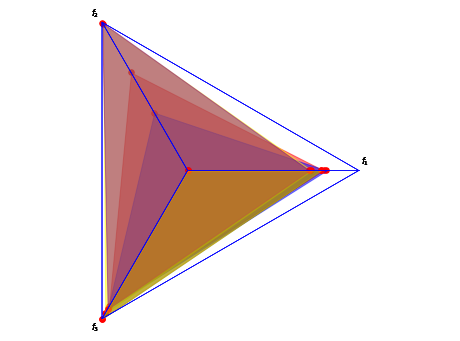

In [71]:
#from pymoo.visualization.radar import Radar

F = np.array([x[1] for x in clf.map_cosd])
#F = 1.0 - F # for better visualization invert the fitness
# ^ done by reverse=True

plot = Radar(bounds=[0, 1],
             axis_style={"color": 'blue'},
             point_style={"color": 'red', 's': 30},
             cmap="tab20",
             #title = ["Solution %s" % t for t in range(len(F))],
             normalize_each_objective=True,
             reverse=True
             #n_partitions=20,
            )

colors = ["red", "blue", "yellow", "green", "purple", "orange"]
for f,c in zip(F, colors):
    plot.add(f, color=c, alpha=0.5)
plot.show()

In [2]:
from pymoo.visualization.star_coordinate import StarCoordinate
from matplotlib.markers import MarkerStyle

F = np.array([x[1] for x in clf.map_cosd])
refs = np.array([x[0] for x in clf.map_cosd])
all_F = np.array(list(clf.PF.values()))

plot = StarCoordinate(title="Optimization",
                      legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                      labels=["O1", "O2", "O3"],
                      axis_style={"color": "blue", 'alpha': 0.7},
                      arrow_style={"head_length": 0.015, "head_width": 0.03})
plot.add(all_F, color="grey", s=20, label="Pareto-front")
# colors are not ideal yet TODO
colors = ["red", "blue", "yellow", "green", "purple", "orange"]
markers = ["o", "v", "*", "s", "d", "P", "x"]
for f,c,r in zip(F, colors, refs):
    lab = f"[{r[0]}, {r[1]}, {r[2]}]"
    plot.add(r, color=c, s=70, marker="X")#, label=lab)
for f,c,m in zip(F, colors, refs):
    plot.add(f, s=70, color=c, label=m) # not sure how to get the markers to work here
#plot.add(F[65], color="red", s=70, label="Solution A")
#plot.add(F[72], color="green", s=70, label="Solution B")

plot.show()

NameError: name 'np' is not defined

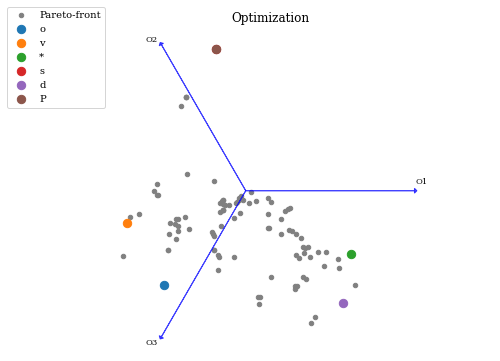

In [97]:
from pymoo.visualization.star_coordinate import StarCoordinate
from matplotlib.markers import MarkerStyle

F = np.array([x[1] for x in clf.map_cosd])
refs = np.array([x[0] for x in clf.map_cosd])
all_F = np.array(list(clf.PF.values()))

plot = StarCoordinate(title="Optimization",
                      legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                      labels=["O1", "O2", "O3"],
                      axis_style={"color": "blue", 'alpha': 0.7},
                      arrow_style={"head_length": 0.015, "head_width": 0.03})
plot.add(all_F, color="grey", s=20, label="Pareto-front")
colors = ["red", "blue", "yellow", "green", "purple", "orange"]
markers = ["o", "v", "*", "s", "d", "P", "x"]

for f,c,m in zip(F, colors, markers):
    plot.add(f, s=70, label=m) # not sure how to get the markers to work here
#plot.add(F[65], color="red", s=70, label="Solution A")
#plot.add(F[72], color="green", s=70, label="Solution B")

plot.show()

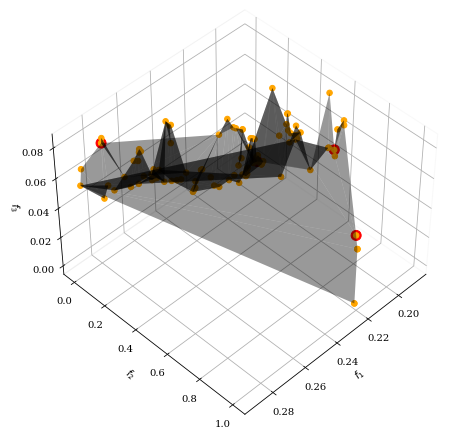

In [50]:
# for full pareto
from pymoo.visualization.scatter import Scatter

F = np.array(list(clf.PF.values()))
plot = Scatter(tight_layout=True)
#plot.add(np.array(clf.preference), plot_type="line", color="green", alpha=0.3)
plot.add(F, s=30, color="orange")
plot.add(F, plot_type="line", color="black", alpha=0.4, linewidth=2)
plot.add(np.array([x[1] for x in clf.preference_direction_to_solution_mapping]), s=100, color="red")
#plot.add(F[10], s=30, color="red")
plot.show()

In [11]:
np.array([x[1] for x in clf.preference_direction_to_solution_mapping])

array([[0.277     , 0.00787568, 0.07432624],
       [0.20766667, 0.26518402, 0.02998822],
       [0.18933333, 0.56337164, 0.0465931 ],
       [0.20366667, 0.83894826, 0.02023814]])

In [6]:
reference_performance_map={}
for a in soln_per_dir: # each 'a' is a survived reference direction
    map_index_to_pred=np.array(soln_per_dir[a])
    in_ts=map_index_to_pred[:,0] #test_instance_indexes
    pred=map_index_to_pred[:,1] #test_predictions
    rs=get_fairness(sa_index,p_Group,in_ts,pred,X,y)
    p=get_score(pred,in_ts,X,y)
    reference_performance_map[a]=[list(rs.values()),p]



For Sensitive attribute index  1
avg_TPR_unprot: 0.7378277153558053 avg_TPR_prot: 0.6818181818181818
avg_TNR_unprot: 0.6026637069922308 avg_TNR_prot: 0.6234756097560976

-------------------------------------------



For Sensitive attribute index  3
avg_TPR_unprot: 0.7330316742081447 avg_TPR_prot: 0.6981981981981982
avg_TNR_unprot: 0.6296715741789355 avg_TNR_prot: 0.5875370919881305

-------------------------------------------



For Sensitive attribute index  4
avg_TPR_unprot: 0.7100271002710027 avg_TPR_prot: 0.7432432432432432
avg_TNR_unprot: 0.6107828655834564 avg_TNR_prot: 0.6157635467980296

-------------------------------------------

avg_TPR: 0.7155756207674944 avg_TNR: 0.6114322414900449
avg_acc: 0.6345 avg_Bacc: 0.6635039311287696
avg_auc: 0.6635039311287697 avg_GM: 0.661457485981903


For Sensitive attribute index  1
avg_TPR_unprot: 0.674631394301427 avg_TPR_prot: 0.6053618711385702
avg_TNR_unprot: 0.6803125711154592 avg_TNR_prot: 0.7269469405220368

-----------------------

In [7]:
results=np.array(list(reference_performance_map.values()))[:,0]
performance=np.array(list(reference_performance_map.values()))[:,1]

['CDM', 'DM', 'CDM', 'DM', 'CDM', 'DM', 'MMM', 'TPR', 'TNR', 'Acc', 'AUC', 'G.Mean']
[[0.0768214363014903, 0.0768214363014903, 0.007301006180858383, 0.07696795820075153, 0.028235461757667335, 0.038196824186813694, 0.0560095335376235, 0.7155756207674944, 0.6114322414900449, 0.6345, 0.6635039311287697, 0.661457485981903], [0.11590389256943445, 0.11590389256943445, 0.03559109374657432, 0.03559109374657432, 0.048815204609794494, 0.048815204609794494, 0.06926952316285684, 0.644469525959368, 0.7007064868336544, 0.68825, 0.6725880063965113, 0.6719464029725308], [0.09224727575059055, 0.09224727575059055, 0.04464134069583836, 0.04464134069583836, 0.0067793877412083425, 0.0344479990251243, 0.06095244538445277, 0.5395033860045146, 0.8124598587026333, 0.752, 0.675981622353574, 0.6615215432196084], [0.007184758297479443, 0.007184758297479443, 0.07851824730662826, 0.07851824730662826, 0.0449154937803401, 0.044915493780340154, 0.058828662463512704, 0.3724604966139955, 0.9039820166987798, 0.78625, 0.6

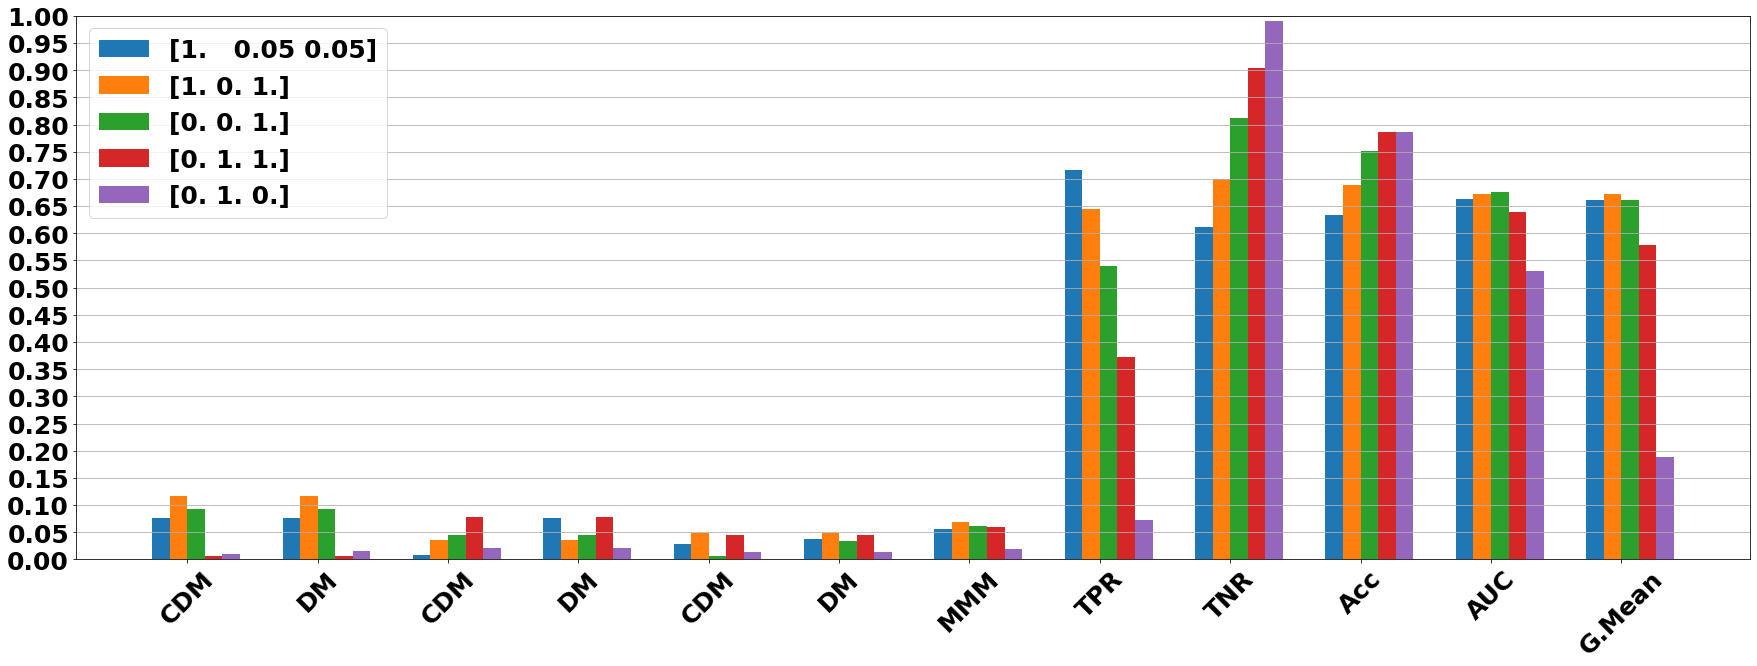

In [8]:
dt='Credit'
vis('',results,performance,L=protected,dt=dt,clfs=list(reference_performance_map.keys()))

In [9]:
protected    #SEX               #MARRIAGE            #AGE

['SEX', 'MARRIAGE', 'AGE']

# Check the anaomaly here [1,1,0] which meaningfully refers to the direction with best fairness has slightly worse fairness than [0,1,0] which refers to direction with best accuracy, fairness trade-off

# 